# COVID-19 country growth analysis


Compares the growth rate of COVID-19 infections within countries.

Important to note:

 - Countries often see a high growth rate in the initial 2-3 weeks due to travellers returning from overseas who (at least in Australia) tend to make up the majority of cases
 - Community transmission is low early and takes hold after this initial 2-3 week period. Countries that are able to slow the community transmission early (by controlling returned travellers through quarantine etc.) have proved most effective in controlling the infection rate
 - It is commonly accepted that infection rates are higher than those reported due to: 
 
  a) lack of availability of testing kits; 
  
  b) strict criteria on who is able to receive a test (due to lack of availability of kits);
  
  c) asymptomatic carriers of the virus (some predictions are around 20%)

In [1]:
# wrangling tools
import numpy as np
import pandas as pd
import datetime as dt

# viz tools
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [2]:
#import sys
#!{sys.executable} -m pip install plotnine

In [3]:
df_c19_all = pd.read_csv('novel-corona-virus-2019-dataset/covid_19_data.csv')
df_c19_all.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
10666,10667,03/31/2020,Wyoming,US,2020-03-31 23:49:27,109.0,0.0,0.0
10667,10668,03/31/2020,Xinjiang,Mainland China,2020-03-31 23:49:27,76.0,3.0,73.0
10668,10669,03/31/2020,Yukon,Canada,2020-03-31 23:49:27,5.0,0.0,0.0
10669,10670,03/31/2020,Yunnan,Mainland China,2020-03-31 23:49:27,182.0,2.0,172.0
10670,10671,03/31/2020,Zhejiang,Mainland China,2020-03-31 23:49:27,1257.0,1.0,1226.0


In [4]:
# initial cleaning, global variables

df_c19_all['ObservationDate'] = pd.to_datetime(df_c19_all['ObservationDate'])
df_c19_all.rename(columns={'Country/Region':'Country'}, inplace=True)

latest_date = str(dt.date.today() - dt.timedelta(days=2))


## Analysis of growth patterns since 100 cases 
#### For countries > 1,000 cases

In [95]:
def latest_over_thresh(df, num_inf):
    
    '''
    Returns a dataframe with the data for all countries that, as of the latest date in the data,
    have over a certain amount of total infections (num_inf). We'll start with 1,000)
    '''
    
    df_latest = df[df['ObservationDate'] == latest_date]
    
    country_list = list(df_latest[df_latest['Confirmed'] >= num_inf].Country)
    df_over_thresh = df[df['Country'].isin(country_list)]
    df_over_thresh = df_over_thresh[['ObservationDate','Country','Confirmed','Deaths', 'Recovered']].groupby(['Country', 'ObservationDate']).sum()
    df_over_thresh.reset_index(inplace=True)
    
    return(df_over_thresh)

In [96]:
df_largest_inf_rates = latest_over_thresh(df_c19_all, 1000)

In [97]:
def days_since_100_cases(df):
    
    '''Take the the dataframe of countries over num_inf (1,000) amount of cases, 
    filter for the period in which country had over 100 cases, 
    then count the number of days since that country reached 100 cases'''

    df_100 = (df
              .query('Confirmed >= 100')
              .sort_values(['Country', 'ObservationDate'])
             )
    
    df_100['Days_since_100'] = df_100.groupby('Country').cumcount()
    df_100 = df_100.reset_index(drop=True)
    
    return(df_100)

In [8]:
df_since_100 = days_since_100_cases(df_largest_inf_rates)
df_since_100.tail()

,Country,ObservationDate,Confirmed,Deaths,Recovered,Days_since_100
1057,US,2020-03-27,101657.0,1581.0,869.0,25
1058,US,2020-03-28,121478.0,2026.0,1072.0,26
1059,US,2020-03-29,140886.0,2467.0,2665.0,27
1060,US,2020-03-30,161807.0,2978.0,5644.0,28
1061,US,2020-03-31,188172.0,3873.0,7024.0,29


Now that we have filtered for :
 
     a) Countries that have over 1,000 total cases (as of today)
 
     b) Dates in which those countries had in excess of 100 cases
 
We will proceed to plot the growth patterns per country. 



We also group countries into infection number brackets. In particular, we are looking for:

     1) Countries with a steeper curve than the majority of others in their group
 
     2) Countries with a flatter ciurve than the majority of others in their groupe

In [9]:
def growth_comparison_lineplot(df, plot_title, label_cond):
    
    '''Takes the filtered dataframe and plots all countries' growth, 
    based on increase in cases since the first 100 cases were recorded in that country
    (i.e. not a strict timeseries based on date)'''
    
    comp_lineplot = (p9.ggplot(df, p9.aes('Days_since_100', 'Confirmed'))
     + p9.geoms.geom_line(p9.aes(colour='Country'))
     + p9.geoms.geom_text(mapping=p9.aes(label='Country'),
                          data = label_cond,
                         size=7, nudge_y=1)
     + p9.scales.scale_colour_discrete(guide=False)
     + p9.themes.theme_bw()
     + p9.theme(figure_size=(7,5))
     + p9.labels.labs(title = plot_title,
                     x = "Days since 100 cases",
                     y = 'Number of cases')
    )

    return(comp_lineplot)

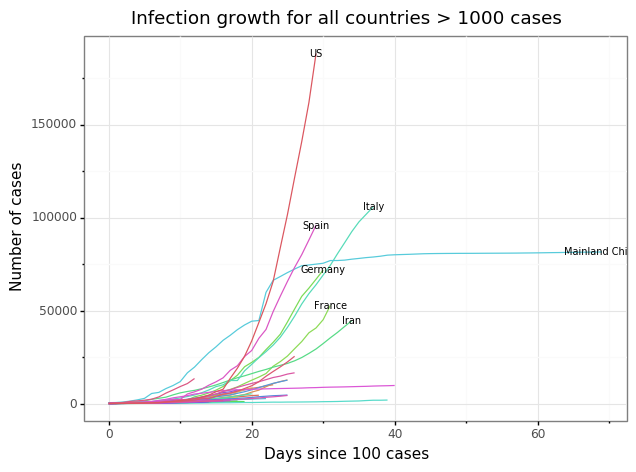

<ggplot: (7547207585)>

In [10]:
# highlight certain countries with a label
line_labels = df_since_100[(df_since_100['ObservationDate']==latest_date) & 
            (df_since_100['Country'].isin(['US', 'Mainland China', 'Italy',
                                'France', 'Spain', 'Iran', 'Germany']))]

growth_comparison_lineplot(df_since_100, 
                           "Infection growth for all countries > 1000 cases",
                          line_labels)

We will now split up the countries into brackets based on the number of cases they had as of the latest date in the data, so we can analyse and compare growth patterns more effectively

In [11]:
def plot_country_bracket(df, lower_lmt, upper_lmt, title):
    
    '''
    Takes the filtered dataframe, and allows specification of an upper and lower limit
    of infection cases as of the latest date. Then plots the specified group.
    '''
    
    df_between = df.groupby('Country').max()
    
    if (lower_lmt > 0 and upper_lmt == 0):
        df_between = df_between[df_between['Confirmed'] >= lower_lmt]
    elif (upper_lmt > 0 and lower_lmt == 0):
        df_between = df_between[df_between['Confirmed'] <= upper_lmt]
    else:
        df_between = df_between[(df_between['Confirmed'] >= lower_lmt) & (df_between['Confirmed'] <= upper_lmt)]    
    
    country_list = list(df_between.index)
    
    df_filtered = df[df['Country'].isin(country_list)]
    
    line_labels = df_filtered[df_filtered['ObservationDate'] == latest_date]
    growth_plot = growth_comparison_lineplot(df_filtered, 
                                             title,
                                            line_labels)
    
    return(growth_plot)

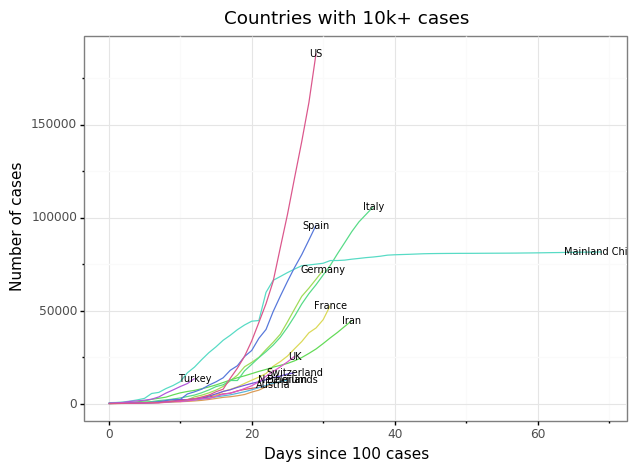

<ggplot: (7547305741)>

In [12]:
plot_country_bracket(df_since_100, 10000, 0, "Countries with 10k+ cases")

Features for countries with 10k+ cases:

 - The US curve is scarily steep
 - China (apparently) have managed to flatten their increase in cases
 - Although Italy has been highlighted as the worst case scenario, Spain appears to overtake Italy based on the shape of growth
 - Germany appears to be following the growth of Italy. However Germany has recorded far less deaths
 - Iran's curve seems to be flattening
 - Keep an eye on Turkey

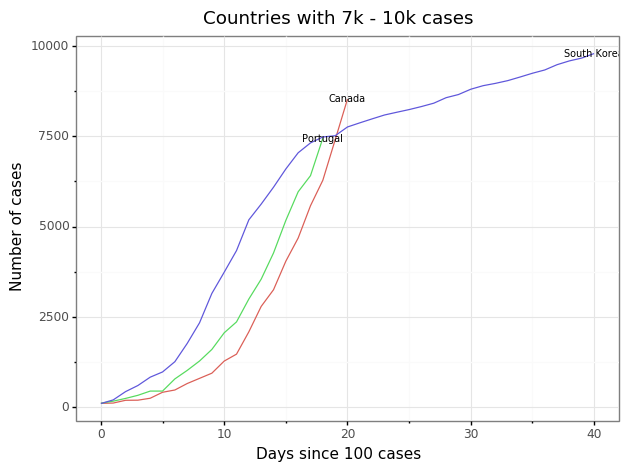

<ggplot: (7547305373)>

In [13]:
plot_country_bracket(df_since_100, 7000, 10000, "Countries with 7k - 10k cases")

Observations for countries with 7k - 10k cases:

 - South Korea has done well to flatten their curve

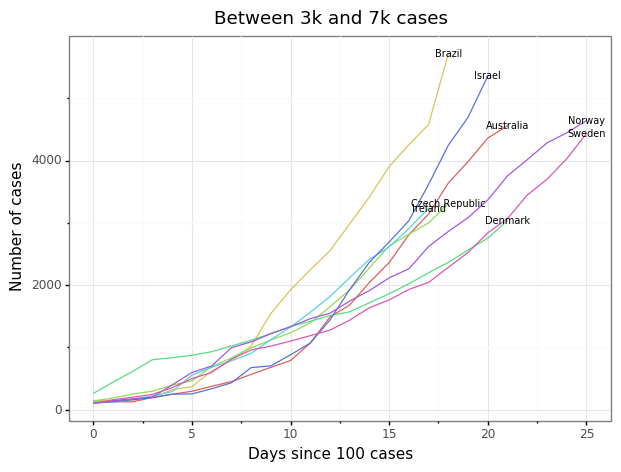

<ggplot: (7547284889)>

In [14]:
plot_country_bracket(df_since_100, 3000, 7000, "Between 3k and 7k cases")

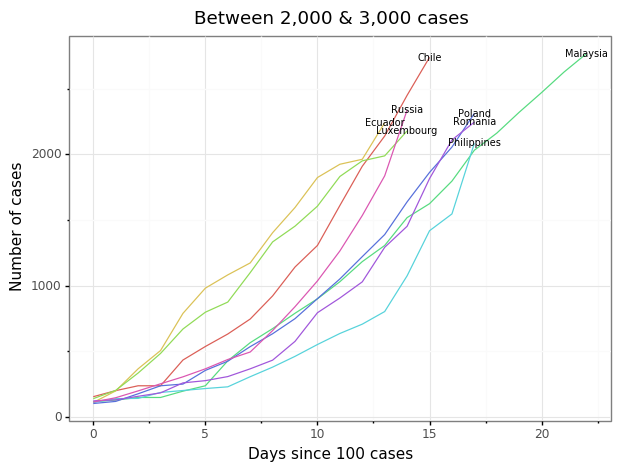

<ggplot: (7548305437)>

In [15]:
plot_country_bracket(df_since_100, 2000, 3000, "Between 2,000 & 3,000 cases")

Observations for countries with 2k to 3k cases:

 - All are following a generally similar growth pattern

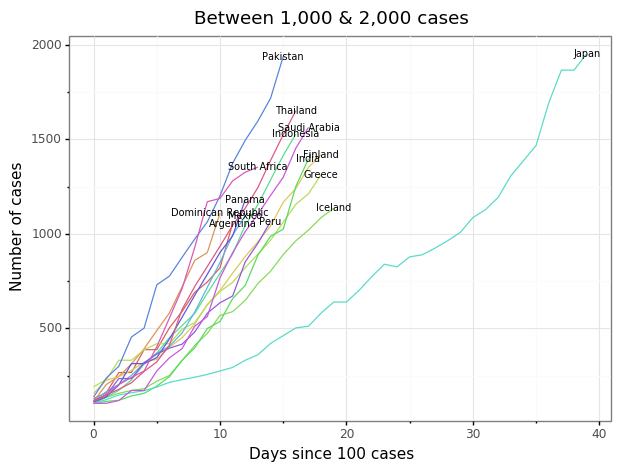

<ggplot: (7548301833)>

In [16]:
plot_country_bracket(df_since_100, 1000, 2000, "Between 1,000 & 2,000 cases")

Observations for countries with 1k to 2k cases:

 - Japan has had the virus much longer than others and has done well to flatten its curve, although growth rate seems to have ticked up again in recent days
 - Ones to watch: Luxembourg (tiny population), Ecuador and Russia

## Percentage increase analysis

### For countries > 1,000 cases, since first 100 cases

Which countries have had the greatest week-on-week percentage increase in cases (i.e. those countries that are struggling to "flatten the curve")



As there are varying numbers of weeks between countries for days since 100 cases, we will plot four comparison graphs:

 - % increase in first week

 - % increase in second week
 
 - % increase in first two weeks

 - % increase in the previous week from today
 

Important considerations when using percentage increase for this analysis:

 - Due to the nature of COVID-19, many people intially display little (or no) symptoms in the initial week after infection, which has meant that, in places like Italy and the US, the virus has spread around communities relatively undetected for a period. In this regard, many countries have recorded a sharp uptick in cases at once, when testing increases, infections persons being to display symptoms, and large numbers of travellers start returning from overseas.
 - We are particular concerned where countries maintain a high percentage increase in cases between the weeks analysed, as this infers that they are struggling to retain the spread.

In [17]:
def percentage_increase_two_weeks(df):
    
    '''
    Filters for the count of cases for each country in the week and fortnight after 
    first recording at least 100 cases, and calculates the % increase in cases, week-on-week
    '''
    
    df_checkpoints = (df
                      .query('Days_since_100 == 0\
                      or Days_since_100 == 7\
                      or Days_since_100 == 14')
                      .set_index(['Country','Days_since_100']).Confirmed
                     )
    
    df_grouped_pct_change = pd.DataFrame(df_checkpoints.groupby(['Country']).pct_change())
    df_grouped_pct_change = pd.DataFrame(df_grouped_pct_change.to_records())
    
    df_grouped_pct_change = (df_grouped_pct_change
                            .assign(Pct_increase = df_grouped_pct_change['Confirmed'] * 100)#df_grouped_pct_change[Confirmed] * 100')
                            .drop('Confirmed', axis=1)
                            .fillna(0)
                            )

    return(df_grouped_pct_change)

In [18]:
df_first_twoWeeks = percentage_increase_two_weeks(df_since_100)
df_first_twoWeeks

,Country,Days_since_100,Pct_increase
0,Argentina,0,0.000000
1,Argentina,7,360.156250
2,Australia,0,0.000000
3,Australia,7,322.429907
4,Australia,14,352.212389
...,...,...,...
129,UK,7,299.130435
130,UK,14,491.721133
131,US,0,0.000000
132,US,7,499.009901


In [89]:
def plot_period_increase(df, days_since_100, week_no):
    
    
    '''
    Function to plot % increase in cases for first and second week since 100 cases
    '''
    
    
    # Filter and order the df for a bar plot
    
    df_week = (df
              .query('Days_since_100 == @days_since_100')
              .sort_values('Pct_increase')
              )

    country_list = df_week['Country'].to_list()
    country_category = pd.Categorical(df_week['Country'],
                                     categories=country_list)
    
    df_week = df_week.assign(country_category=country_category)
    
    
    # Build bar plot
    
    p9.options.figure_size = (7,10)
    
    country_week_plot = (p9.ggplot(df_week, p9.aes(x = 'country_category', y='Pct_increase'))
                         + p9.coords.coord_flip()
                         + p9.geoms.geom_col(stat='identity')
                         + p9.themes.theme_bw()
                         + p9.labels.labs(title = "Percentage increase in cases in {} week".format(week_no),
                                          y = 'Percentage increase',
                                          x = 'Country')
                        )
    return(country_week_plot)

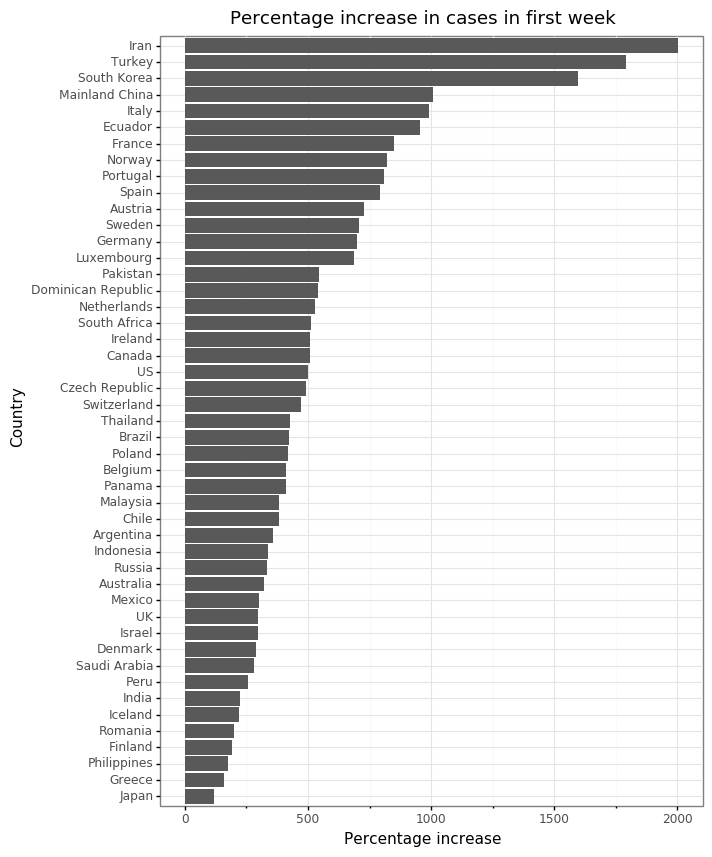

<ggplot: (7550283985)>

In [90]:
plot_period_increase(df_first_twoWeeks, 7, "first")

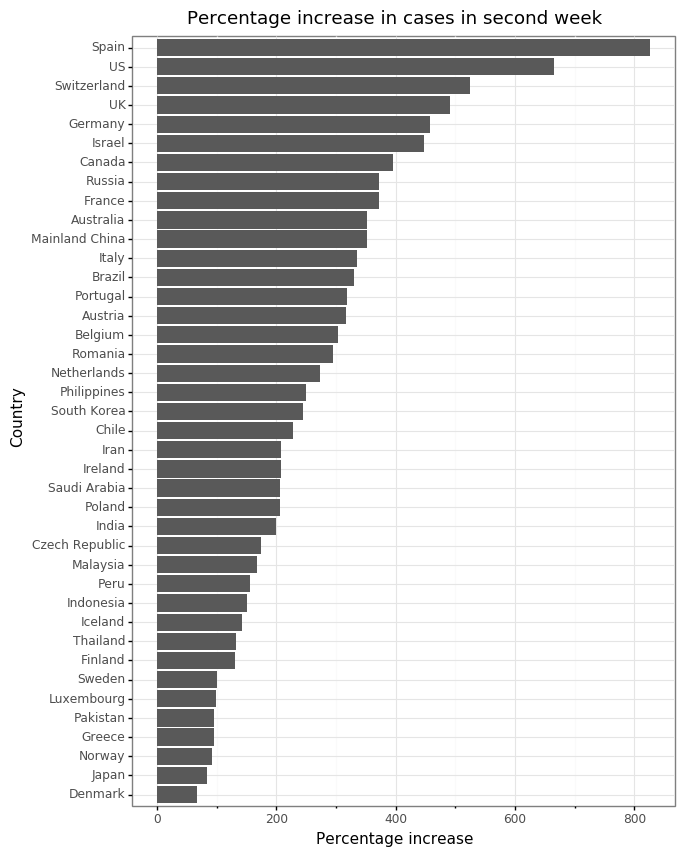

<ggplot: (7550601561)>

In [91]:
plot_period_increase(df_first_twoWeeks, 14, "second")

In [40]:
def calc_WoWincrease_change(df):
    
    '''
    Calculates the difference in % increase between week one and week two. 
    Countries who report an "increase in the % increase" are struggling to "flatten the curve" 
    '''
    
    df_wow_filtered = df[df['Days_since_100'] != 0]
    df_wow_pivoted = df_wow_filtered.pivot('Country', 'Days_since_100', 'Pct_increase')
    df_wow_pivoted = (df_wow_pivoted
                      .reset_index(drop=False)
                      .rename(columns = {7:'perc_increase_week_after_100_cases',
                                        14:'perc_increase_second_week'})
                     )
    df_wow_pivoted['WoW_increase_change'] =\
        df_wow_pivoted['perc_increase_second_week'] - df_wow_pivoted['perc_increase_week_after_100_cases']
    
    
    return(df_wow_pivoted)

In [41]:
df_wow_change = calc_WoWincrease_change(df_first_twoWeeks)
df_wow_change.sort_values('WoW_increase_change', ascending=False).head(10)

Days_since_100,Country,perc_increase_week_after_100_cases,perc_increase_second_week,WoW_increase_change
45,UK,299.130435,491.721133,192.590698
46,US,499.009901,665.619835,166.609934
20,Israel,297.247706,447.113164,149.865458
35,Romania,198.373984,295.640327,97.266343
32,Philippines,176.576577,250.162866,73.586290
42,Switzerland,471.929825,525.000000,53.070175
36,Russia,334.210526,372.121212,37.910686
40,Spain,794.166667,826.561044,32.394377
1,Australia,322.429907,352.212389,29.782483
16,India,223.529412,199.090909,-24.438503


In [42]:
df_wow_change.sort_values('WoW_increase_change', ascending=False).head(10)

Days_since_100,Country,perc_increase_week_after_100_cases,perc_increase_second_week,WoW_increase_change
45,UK,299.130435,491.721133,192.590698
46,US,499.009901,665.619835,166.609934
20,Israel,297.247706,447.113164,149.865458
35,Romania,198.373984,295.640327,97.266343
32,Philippines,176.576577,250.162866,73.586290
42,Switzerland,471.929825,525.000000,53.070175
36,Russia,334.210526,372.121212,37.910686
40,Spain,794.166667,826.561044,32.394377
1,Australia,322.429907,352.212389,29.782483
16,India,223.529412,199.090909,-24.438503


In [92]:
def increase_first_two_weeks(df):
    
    '''
    Calculates the total % increase in infections for the fortnight since first recording 100 cases
    '''
    
    
    df_filtered = df[(df['Days_since_100'] == 0) |
                     (df_since_100['Days_since_100'] == 14)]
    
    df_pivot = df_filtered.pivot('Country', 'Days_since_100', 'Confirmed')
    df_pivot = (df_pivot
               .assign(Increase = df_pivot[14] - df_pivot[0],
                      Perc_increase = (df_pivot[14] - df_pivot[0]) / df_pivot[0]) 
               .rename(columns = {0:'Week_0',
                                 14:'Week_2'})
               )
    
    df_pivot = (df_pivot
               .query('Perc_increase > 0')
               .sort_values('Perc_increase', ascending=False)
               )
    
    return(df_pivot)

In [93]:
two_week_increase = increase_first_two_weeks(df_since_100)
two_week_increase.head(10)

Days_since_100,Week_0,Week_2,Increase,Perc_increase
Country,,,,
Spain,120.0,9942.0,9822.0,81.850000
Iran,139.0,9000.0,8861.0,63.748201
South Korea,104.0,6088.0,5984.0,57.538462
Mainland China,547.0,27409.0,26862.0,49.107861
Italy,155.0,7375.0,7220.0,46.580645
US,101.0,4632.0,4531.0,44.861386
France,100.0,4480.0,4380.0,43.800000
Germany,130.0,5795.0,5665.0,43.576923
Portugal,112.0,4268.0,4156.0,37.107143


In [94]:
one_week_ago = str(dt.date.today() - dt.timedelta(days=9))

In [98]:
def increase_last_week(df):

    '''
    Calculates the % increase in cases in each country in the last week 
    (i.e. the week up until the latest date in the data)
    '''
    
    df_last_week = (df
                 .query('ObservationDate == @one_week_ago or ObservationDate == @latest_date')
                 .set_index(['Country']).Confirmed
                 )
    df_last_week_pc_change = pd.DataFrame(df_last_week.groupby(['Country']).pct_change())
    df_last_week_pc_change = pd.DataFrame(df_last_week_pc_change.to_records())
    df_last_week_pc_change = (df_last_week_pc_change
                           .query('Confirmed > 0')
                           .assign(Pct_increase = df_last_week_pc_change['Confirmed'] * 100)
                           .drop('Confirmed', axis=1)
                           .sort_values('Pct_increase', ascending=False)
                           )
    
    return(df_last_week_pc_change)

In [99]:
df_last_week = increase_last_week(df_since_100)
df_last_week.head()

,Country,Pct_increase
89,Turkey,622.809829
73,Russia,372.121212
65,Philippines,277.536232
19,Dominican Republic,255.448718
93,US,250.152587


In [100]:
def plot_prior_week_increase(df):
    
    '''
    Plots the % increase in cases in the past week
    '''
    
    df_last_week = df.sort_values('Pct_increase')

    country_list = df_last_week['Country'].to_list()
    country_category = pd.Categorical(df_last_week['Country'],
                                     categories=country_list)
    
    df_last_week = df_last_week.assign(country_category=country_category)
    
    p9.options.figure_size = (7,9)
    plot_last_week = (p9.ggplot(df_last_week,
               p9.aes(x = 'country_category', y='Pct_increase'))
     + p9.coords.coord_flip()
     + p9.geoms.geom_col(stat='identity')
     + p9.themes.theme_bw()
     + p9.labels.labs(title = "Percentage increase in cases in last week",
                      y = 'Percentage increase')
    )
    
    return(plot_last_week)

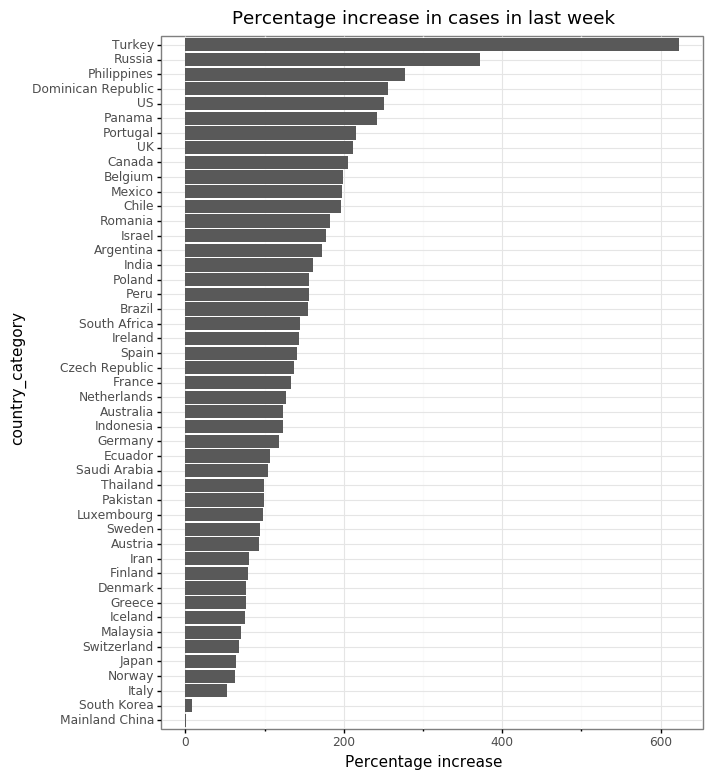

<ggplot: (7548240117)>

In [101]:
plot_prior_week_increase(df_last_week)

## Daily change analysis

Analyse the shape of certain countries' daily change in cases

In [45]:
def daily_change(df):
    
    '''
    Returns a dataframe with the daily change in confirmed cases and deaths for each country
    '''

    df_since_last = (df
                    .set_index(['Country', 'ObservationDate'])
                    .groupby(['Country']).diff()
                    )
    
    df_since_last = pd.DataFrame(df_since_last.to_records())
    df_since_last = (df_since_last
                     .rename(columns = {'Confirmed':'Change_in_cases',
                                                   'Deaths':'Change_in_deaths'})
                     .drop(['Days_since_100','Recovered'], axis=1)
                    )
    
    return(df_since_last)

In [102]:
df_daily_changes = daily_change(df_since_100)
df_daily_changes

,Country,ObservationDate,Change_in_cases,Change_in_deaths
0,Argentina,2020-03-20,NaN,NaN
1,Argentina,2020-03-21,30.0,1.0
2,Argentina,2020-03-22,108.0,0.0
3,Argentina,2020-03-23,0.0,0.0
4,Argentina,2020-03-24,121.0,2.0
...,...,...,...,...
1057,US,2020-03-27,17821.0,372.0
1058,US,2020-03-28,19821.0,445.0
1059,US,2020-03-29,19408.0,441.0
1060,US,2020-03-30,20921.0,511.0


In [394]:
def plot_daily_change(df, metric, country_group):
    
    
    df = df[df['Country'].isin(country_group)].fillna(0)
    
    p9.options.figure_size = (7,5)
    
    plot_daily_change = (p9.ggplot(df,
               p9.aes(x = 'ObservationDate', y= metric))
     + p9.geoms.geom_col(stat='identity')
     + p9.facets.facet_wrap('Country')       
     + p9.scales.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y'))
     + p9.themes.theme_bw()
     + p9.labels.labs(title = "Daily increase in confirmed cases over time",
                      y = 'Change in number of cases',
                      x = 'Time')
                         
    )
                 
    return(plot_daily_change)            

In [457]:
bins = [2000, 3000, 4000, 5000, 10000, 15000, 80000, 200000]
df_latest_no_cases = df_since_100[df_since_100['ObservationDate'] == latest_date].sort_values('Confirmed')
df_latest_no_cases['bin'] = pd.cut(df_latest_no_cases['Confirmed'], bins).astype(str)


bin_list = df_latest_no_cases['bin'].unique()
country_list = []

for i in bin_list:
    
    country_list.append(df_latest_no_cases['Country'][df_latest_no_cases['bin'] == i].tolist())

country_list[3]

['Sweden', 'Australia', 'Norway']

In [471]:
def create_country_groups(df):
    
    '''
    Takes the filtered dataframe and groups them based on the number
    of cases they had as of the lastest date in the data.
    Returns these groups as lists to pass into the plot function
    '''
    
    bins = [2000, 3000, 4000, 5000, 10000, 15000, 80000, 200000]
    
    df_latest = df[df['ObservationDate'] == latest_date]
    df_latest['group'] = pd.cut(df_latest['Confirmed'], bins).astype(str)
    
    group_list = df_latest['group'].unique()
    
    country_list = []
    
    for i in group_list:
        
        country_list.append(df_latest['Country'][df_latest['group'] == i].tolist())
    
    return(country_list)
    

In [487]:
countries_grouped = create_country_groups(df_latest_no_cases)
len(countries_grouped)

8

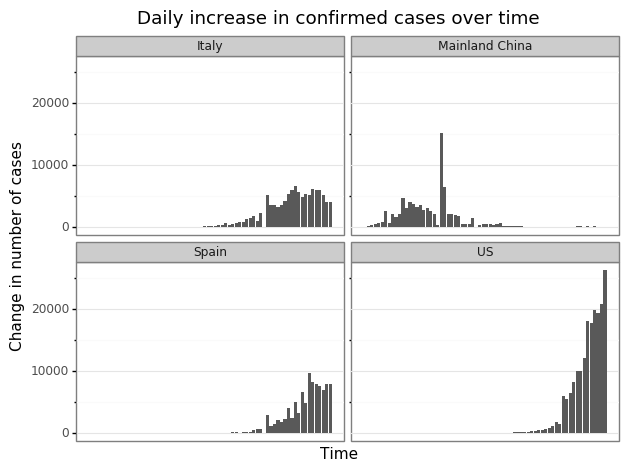

<ggplot: (7555700989)>

In [489]:
plot_daily_change(df_daily_changes, 'Change_in_cases', countries_grouped[7])

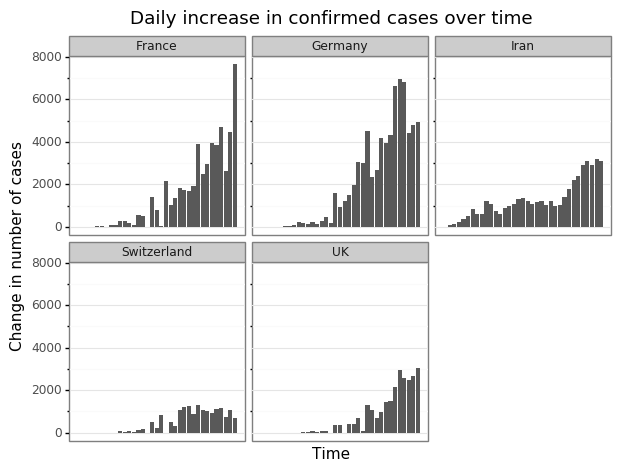

<ggplot: (7548341541)>

In [490]:
plot_daily_change(df_daily_changes, 'Change_in_cases', countries_grouped[6])

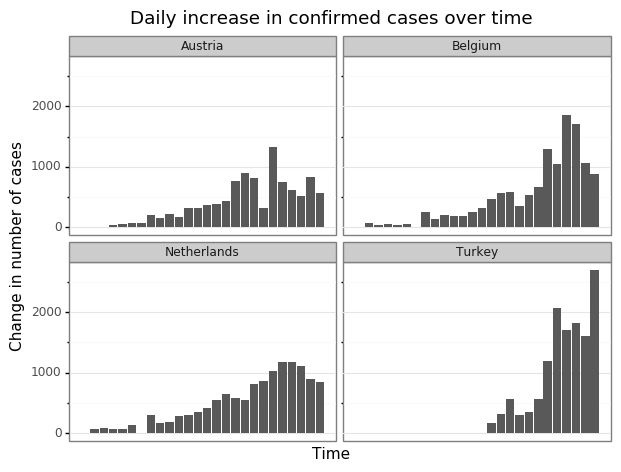

<ggplot: (7553122653)>

In [491]:
plot_daily_change(df_daily_changes, 'Change_in_cases', countries_grouped[5])

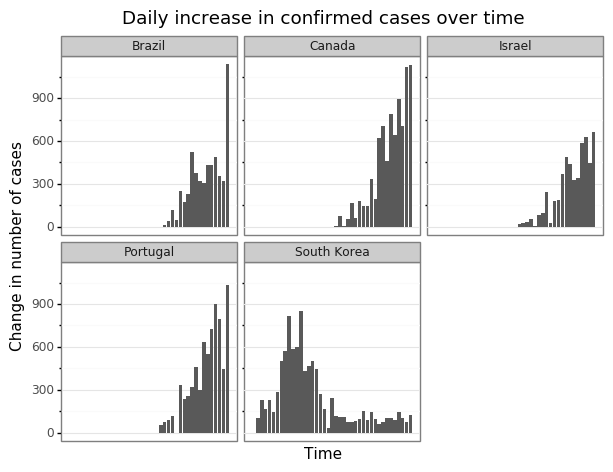

<ggplot: (7555747513)>

In [492]:
plot_daily_change(df_daily_changes, 'Change_in_cases', countries_grouped[4])

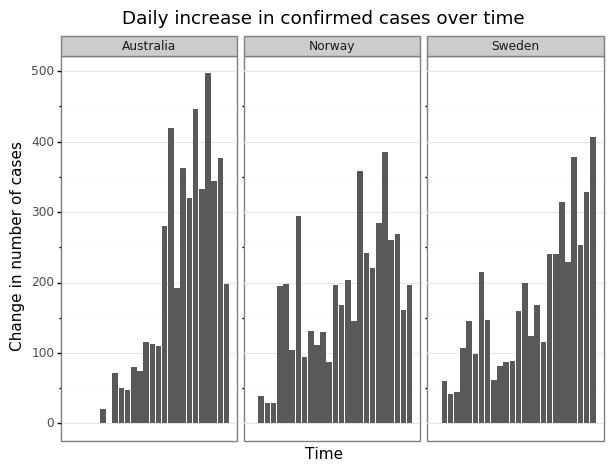

<ggplot: (7559943393)>

In [493]:
plot_daily_change(df_daily_changes, 'Change_in_cases', countries_grouped[3])

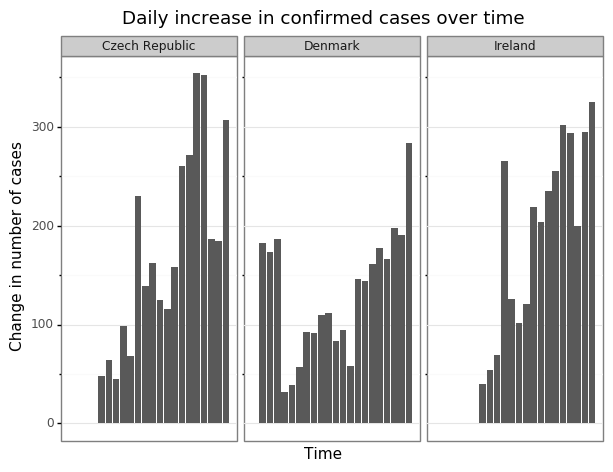

<ggplot: (7560597157)>

In [494]:
plot_daily_change(df_daily_changes, 'Change_in_cases', countries_grouped[2])

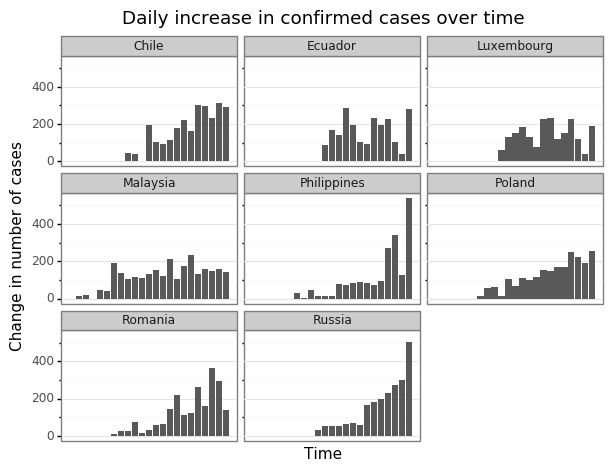

<ggplot: (7554733181)>

In [495]:
plot_daily_change(df_daily_changes, 'Change_in_cases', countries_grouped[1])

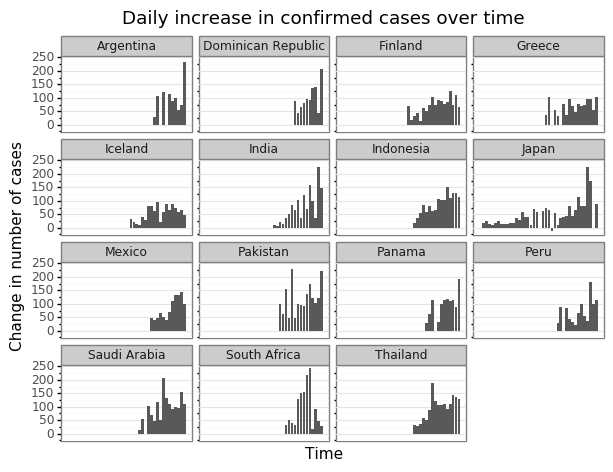

<ggplot: (7560291001)>

In [496]:
plot_daily_change(df_daily_changes, 'Change_in_cases', countries_grouped[0])